<a href="https://colab.research.google.com/github/nitinfaye/Movies-predictions/blob/main/movie_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-multilearn
!pip install -U scikit-learn


     |████████████████████████████████| 92kB 6.5MB/s 
     |████████████████████████████████| 22.3MB 47.3MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
import os
import csv
import datetime
import joblib
import warnings

import numpy as np
import pandas as pd

from random import Random

from argparse import ArgumentParser

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.adapt import MLkNN
from skmultilearn.ensemble import RakelD

from scipy.stats import poisson
from scipy.stats import uniform

import matplotlib.pyplot as plt

In [ ]:
pd.options.display.max_columns = 498551

In [ ]:
# Максимальное количество значимых токенов, используется при векторизации описания фильма
MAX_FEATURES = 498551

In [ ]:
ALL_GENRES = [
    'absurd',
    'action',
    'adult comedy',
    'allegory',
    'alternate history',
    'alternate reality',
    'anti war',
    'atmospheric',
    'autobiographical',
    'avant garde',
    'blaxploitation',
    'bleak',
    'boring',
    'brainwashing',
    'christian film',
    'claustrophobic',
    'clever',
    'comedy',
    'comic',
    'cruelty',
    'cult',
    'cute',
    'dark',
    'depressing',
    'dramatic',
    'entertaining',
    'fantasy',
    'feel-good',
    'flashback',
    'good versus evil',
    'gothic',
    'grindhouse film',
    'haunting',
    'historical',
    'historical fiction',
    'home movie',
    'horror',
    'humor',
    'insanity',
    'inspiring',
    'intrigue',
    'magical realism',
    'melodrama',
    'murder',
    'mystery',
    'neo noir',
    'non fiction',
    'paranormal',
    'philosophical',
    'plot twist',
    'pornographic',
    'prank',
    'psychedelic',
    'psychological',
    'queer',
    'realism',
    'revenge',
    'romantic',
    'sadist',
    'satire',
    'sci-fi',
    'sentimental',
    'storytelling',
    'stupid',
    'suicidal',
    'suspenseful',
    'thought-provoking',
    'tragedy',
    'violence',
    'western',
    'whimsical'
]

In [ ]:
# Все модели, которые мы можем обучить.
ALL_MODELS = [
    # Binary Relevance с использованием наивного Байесовского классификатора
    "br_nb",
    # Binary Relevance с использованием логистической регрессии
    "br_log",
    "br_log2",
    # Binary Relevance с использованием дерева принятия решений
    "br_tree",
    # Binary Relevance с использованием дерева принятия решений и перебора гиперпараметров
    #"br_tree_gs",
    # Binary Relevance с использованием дерева принятия решений и
    # случайного перебора гиперпараметров
    #"br_tree_rs",
    # Binary Relevance с использованием градиентного бустинга
    #"br_gb",
    # Binary Relevance с использованием градиентного бустинга и перебора гиперпараметров
    #"br_gb_gs",
    # Цепочка наивных Байесовских классификаторов
    "clc_nb",
    # Цепочка логистических регрессий
    "clc_log",
    # Цепочка решающих деревьев
    "clc_tree",
    # Цепочка решающих деревьев с перебором гиперпараметров
    #"clc_tree_gs",
    # Цепочка решающих деревьев со случайным перебором гиперпараметров
    #"clc_tree_rs",
    # Цепочка градиентных бустингов
    #"clc_gb",
    # Цепочка градиентных бустингов с перебором гиперпараметров
    #"clc_gb_gs",
    # Label Powerset на основе наивного Байесовского классификатора
    "lp_nb",
    # Label Powerset на основе логистической регрессии
    "lp_log",
    # LabelPowerset на основе решающих деревьев
    "lp_tree",
    # LabelPowerset на основе решающих деревьев с перебором гиперпараметров
    #"lp_tree_gs",
    # Адаптированный алкоритм K ближайших соседей
    #"mlknn",
    # Адаптированный алкоритм K ближайших соседей + GridSearch
    #"mlknn_gs",
    # Адаптированный алкоритм K ближайших соседей + RandomizedSearch
    #"mlknn_rs",
    # Случайное разделение множества меток на основе наивных Байесовских
    # классификаторов
    #"rakeld_nb",
    # Случайное разделение множества меток на основе решающих деревьев
    #"rakeld_tree"
]

In [ ]:
def create_model(model_type):
    """
    Возвращает объект необученного классификатора заданного типа

    Параметры
    ---------
    model_type : str
        Одна из строк, входящих в набор ALL_MODELS

    Возвращает
    ----------
    model : skmultilearn.Estimator
        Необученный мультиклассификатор заданного типа
    """
    if model_type == "br_nb":
        return BinaryRelevance(
            classifier=BernoulliNB(),
            require_dense=[True, True],
        )
    if model_type == "br_log":
        return BinaryRelevance(
            SGDClassifier(loss='hinge', alpha=0.00001, penalty='l2', n_jobs=-1)
        )
    if model_type == "br_log2":
        return BinaryRelevance(
            classifier=LogisticRegression(solver='sag'),
            require_dense=[True, True],
        )
    if model_type == "br_tree":
        return BinaryRelevance(
            classifier=DecisionTreeClassifier(random_state=123, max_depth=5),
            require_dense=[True, True],
        )
    if model_type == "clc_nb":
        return ClassifierChain(
            classifier=BernoulliNB(),
            require_dense=[True, True],
        )
    if model_type == "clc_log":
        return ClassifierChain(
            classifier=LogisticRegression(solver='sag'),
            require_dense=[True, True],
        )
    if model_type == "clc_tree":
        return ClassifierChain(
            classifier=DecisionTreeClassifier(random_state=123, max_depth=5),
            require_dense=[True, True],
        )
    if model_type == "lp_nb":
        return LabelPowerset(
            classifier=BernoulliNB(),
            require_dense=[True, True],
        )
    if model_type == "lp_log":
        return LabelPowerset(
            classifier=LogisticRegression(),
            require_dense=[True, True],
        )
    if model_type == "lp_tree":
        return LabelPowerset(
            classifier=DecisionTreeClassifier(random_state=123, max_depth=5),
            require_dense=[True, True],
       )
    """
    if model_type == "mlknn":
        return MLkNN(
            classifier =MLkNN(random_state=123, max_depth= 5),
            require_dense=[True, True]
        )
    if model_type == "rakeld_nb":
        return RakelD(
            base_classifier=BernoulliNB(),
            base_classifier_require_dense=[True, True],
        )
    if model_type == "rakeld_tree":
        return RakelD(
            base_classifier=DecisionTreeClassifier(random_state=123, max_depth=5),
            base_classifier_require_dense=[True, True]
        )
     """
    raise ValueError("Неизвестный тип классификатора {}".format(model_type))

In [ ]:
def create_sample(data,
                  min_size: int,
                  min_total: int = None,
                  output_filename: str = None):
    """
    Выбирает из матрицы данных data случайным образом несколько фильмов
    таким образом, чтобы в выборке оказались как минимум min_size
    фильмов каждого жанра. Записывает выборку в csv-файл output_filename,
    если имя файла не None. Также возвращает выборку в виде объекта
    pandas.DataFrame

    Требует наличия глобальной списочной переменной ALL_GENRES, содержащей
    список строк. Все эти строки должны присутствовать среди имен столбцов
    data

    Параметры
    ---------
    data : pandas.DataFrame
        Исходная матрица данных, строки которой, как предполагаются,
        соответствуют фильмам

    min_size : int
        Минимальное количество фильмов каждого жанра, которые должны
        попасть в итоговую выборку. Это означает, что для каждого имени
        столбца, входящего в список ALL_GENRES, в выборке окажется не менее
        этого количества строк, для которых этот столбец равен 1.

    min_total : int, необязателен
        Если задан, то обязательно возвращается выборка, содержащая не менее
        этого числа фильмов. Будет выброшено исключение, если это значение
        больше количества строк в data

    output_filename : str, необязателен
        Если не равен None, то возвращаемое значение также будет записано
        в этот файл в формате CSV. Возвращено оно будет все равно

    Возвращает
    ----------
    sample : pandas.DataFrame
        Выборка из фрейма данных data. Гарантированно содержит не менее
        min_size фильмов каждого жанра и менее min_total фильмов всего,
        если значение min_total не равно None
    """
    rnd = Random()
    if "split" in data.columns:
        # При наличии колонки split пытаемся сделать выборку, содержащую
        # фильмы каждого жанра для каждого из значений split
        ids = set()
        for group in set(data["split"]):
            s = create_sample(
                data.loc[data.split == group].drop('split', axis='columns'),
                min_size=min_size * (3 if group == 'train' else 1),
                output_filename = None
            )
            ids = ids.union(set(s.index))
    else:
        # Выбираем небольшое подмножество фильмов для каждого жанра и
        # объединяем их все
        ids = set()
        for genre in ALL_GENRES:
            chunk = data.loc[data[genre] == 1]
            ids = ids.union(
                set(
                    rnd.sample(list(chunk.index), min(min_size, len(chunk)))
                )
            )
    if min_total and min_total > len(ids):
        # Если задано минимальное общее количество фильмов в выборке, а
        # наша выборка фильмов меньше, то дополняем ее до этого количества.
        ids = ids.union(
            rnd.sample(set(data.index) - ids, min_total - len(ids))
        )
    sample = data.loc[sorted(ids)]
    if output_filename:
        sample.to_csv(output_filename, quoting=csv.QUOTE_ALL)
    return sample

In [ ]:
def split_data(data, max_features: int = MAX_FEATURES):
    """
    Разбивает данные на обучающие и тестовые

    Параметры
    ---------
    data : pandas.DataFrame
        Исходная матрица данных

    max_features : int
        Максимальное количество возвращаемых признаков. Может равняться
        None, чтобы не ограничивать количество возвращаемых признаков

    Возвращает
    ----------
    X_train : numpy.ndarray (test_size, num_features)
        Признаки для обучения

    X_test : numpy.ndarray (test_size, num_featrues)
        Признаки для тестирования

    Y_train : numpy.ndarray (test_size, num_genres)
        Целевые метки для обучения

    Y_test = numpy.ndarray (test_size, num_genres)
        Целевые метки для тестирования
    """
    data_train = data.loc[(data["split"] == "train") | (data["split"] == "val")]
    data_test = data.loc[data.split == 'test']
    Y_train = data_train[ALL_GENRES]
    Y_test = data_test[ALL_GENRES]
    vectorizer = TfidfVectorizer(strip_accents='unicode', max_df=0.8, min_df=5, use_idf=True, sublinear_tf=True, norm='l2', max_features=MAX_FEATURES)
    vectorizer.fit(data_train.lemmas)
    X_train = vectorizer.transform(data_train.lemmas)
    X_test = vectorizer.transform(data_test.lemmas)
    return (X_train, X_test, Y_train.values, Y_test.values)

In [ ]:
def train_models(data, max_features: int = MAX_FEATURES, output_path: str = None):
    """
    Обучает модели классификации по жанрам на наборе данных data и сохраняет
    их в каталоге output_path
    
    Возвращает
    ----------
    all_models : dict
        Словарь, содержащий все обученные мультиклассификаторы, индексируемые
        их строковыми обозначениями из списка ALL_MODELS
    """
    results = pd.DataFrame(
        columns=["Model", "Accuracy", "Hamming Loss", "Precision", "Recall", "F1", "Time"]
    )
    models = {}
    (X_train, X_test, Y_train, Y_test) = split_data(
        data, max_features=max_features
    )
    for model_type in ALL_MODELS:
        print("Обучается модель {}...".format(model_type))
        start = datetime.datetime.now()
        model = create_model(model_type)
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(Y_test, y_pred)
        hloss = hamming_loss(Y_test, y_pred)
        precision = precision_score(Y_test, y_pred, average='micro')
        recall = recall_score(Y_test, y_pred, average='micro')
        f1 = f1_score(Y_test, y_pred, average='micro')
        end = datetime.datetime.now()
        results = results.append(
            pd.Series(
                {
                    "Model": model_type,
                    "Accuracy": accuracy,
                    "Hamming Loss": hloss,
                    "Precision": precision, 
                    "Recall": recall, 
                    "F1": f1,
                    "Time": (end - start).total_seconds()
                }
            ),
            ignore_index=True
        )
        models[model_type] = model
        if output_path:
            os.makedirs(output_path, exist_ok=True)
            filename = os.path.join(output_path, "{}.dat".format(model_type))
            joblib.dump(model, filename)
    return (models, results)

In [ ]:
def predict_movie(data,
                  model,
                  *,
                  movie_id: str,
                  max_features: int = MAX_FEATURES):
    """
    Выводит на экран оригинальное и предсказанное значение жанра для
    определенного фильма
    
    Параметры
    ---------
    data : pandas.DataFrame
        Матрица данных с информацией о фильмах

    model : str или skmultilearn.Estimator
        Модель для предсказания жанров или имя файла, хранящего такую модель
    
    movie_id : str
        Идентификатор фильма, для которого смотрим значения жанра
    """
    data_train = data.loc[(data["split"] == "train") | (data["split"] == "val")]
    vectorizer = TfidfVectorizer(strip_accents='unicode', max_df=0.8, min_df=5, use_idf=True, sublinear_tf=True, norm='l2', max_features=MAX_FEATURES)
    vectorizer.fit(data_train.lemmas)
    X = vectorizer.transform([data.loc[movie_id, "lemmas"]])
    if isinstance(model, str):
        model = joblib.load(model)
    y_true = data.loc[movie_id, ALL_GENRES]
    y_pred = np.ravel(y_pred)
    print("Movie: {}".format(data.loc[movie_id, "title"]))
    print(
        "Actual genres: {}".format(
            ", ".join([x for (i, x) in enumerate(ALL_GENRES) if y_true.ravel()[i] > 0])
        )
    )
    print(
        "Predicted genres: {}".format(
            ", ".join([x for (i, x) in enumerate(ALL_GENRES) if y_pred.ravel()[i] > 0])
        )
    )

3time reapet click on data atomatcilaly file loaded with using alternate data

In [ ]:
data = pd.read_csv("/content/Lemmas.csv").set_index('imdb_id')
#data =pd.read_csv(open('/content/Lemmas.csv','rU'), encoding='utf-8', engine='python')

In [ ]:
from random import Random
sample = create_sample(data, 10, 1500)
#sample = data

In [ ]:
data.split.value_counts(normalize=True)

train    0.629157
test     0.207565
val      0.163278
Name: split, dtype: float64

In [ ]:
sample.split.value_counts(normalize=True)

train    0.622986
test     0.195081
val      0.181934
Name: split, dtype: float64

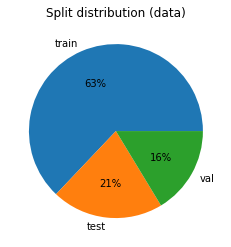

In [ ]:
classes = pd.value_counts(data["split"])
classes.plot(kind = 'pie', autopct='%0.f%%') 
plt.title("Split distribution (data)")
plt.ylabel('')
plt.show()

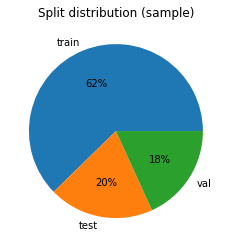

In [ ]:
classes = pd.value_counts(sample["split"])
classes.plot(kind = 'pie', autopct='%0.f%%') 
plt.title("Split distribution (sample)")
plt.ylabel('')
plt.show()

In [ ]:
(all_models, results) = train_models(sample)

Обучается модель br_nb...
Обучается модель br_log...
Обучается модель br_log2...
Обучается модель br_tree...
Обучается модель clc_nb...
Обучается модель clc_log...
Обучается модель clc_tree...
Обучается модель lp_nb...
Обучается модель lp_log...
Обучается модель lp_tree...


In [ ]:
print(results)

      Model  Accuracy  Hamming Loss  Precision    Recall        F1        Time
0     br_nb  0.002174      0.130557   0.265572  0.311523  0.286718   35.254226
1    br_log  0.002174      0.080465   0.552699  0.234460  0.329250   58.223472
2   br_log2  0.004348      0.076883   0.804569  0.115231  0.201590  420.202291
3   br_tree  0.008696      0.087416   0.454939  0.190840  0.268886  179.725653
4    clc_nb  0.002174      0.133833   0.256757  0.310796  0.281204   62.968693
5   clc_log  0.002174      0.082701   0.867647  0.021447  0.041859  546.254518
6  clc_tree  0.010870      0.085058   0.487580  0.192657  0.276186   74.967501
7     lp_nb  0.000000      0.098316   0.000000  0.000000  0.000000    5.364432
8    lp_log  0.002174      0.098071   0.008696  0.001454  0.002491  155.587632
9   lp_tree  0.002174      0.097642   0.023913  0.003999  0.006851   14.099159


In [ ]:
results.to_csv('model-stats.csv', encoding='utf-8', index=False)

In [ ]:
results = pd.read_csv("model-stats.csv")

In [ ]:
results

,Model,Accuracy,Hamming Loss,Precision,Recall,F1,Time
0,br_nb,0.002174,0.130557,0.265572,0.311523,0.286718,35.254226
1,br_log,0.002174,0.080465,0.552699,0.234460,0.329250,58.223472
2,br_log2,0.004348,0.076883,0.804569,0.115231,0.201590,420.202291
3,br_tree,0.008696,0.087416,0.454939,0.190840,0.268886,179.725653
4,clc_nb,0.002174,0.133833,0.256757,0.310796,0.281204,62.968693
5,clc_log,0.002174,0.082701,0.867647,0.021447,0.041859,546.254518
6,clc_tree,0.010870,0.085058,0.487580,0.192657,0.276186,74.967501
7,lp_nb,0.000000,0.098316,0.000000,0.000000,0.000000,5.364432
8,lp_log,0.002174,0.098071,0.008696,0.001454,0.002491,155.587632
9,lp_tree,0.002174,0.097642,0.023913,0.003999,0.006851,14.099159
